In this notebook, we will explore time-based anomalies in the market. We assume that because of the high amount of uninformed investors, that it is more likely that these anomalies will exist, given the superstitious beliefs and actions carried out by them.

In [2]:
%matplotlib inline

from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *

import talib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykalman as kf
import scipy.stats
import statsmodels.api as sm
import statsmodels
import sklearn
import requests
import quandl
import time

from scipy.signal import correlate
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
mpl.rcParams['figure.dpi'] = 150 # Higher quality graphs
plt.rcParams['figure.figsize'] = [10, 6] # Wider graphs

In [4]:
# For each cryptocurrency being traded on GDAX, we will gather two pairs to represent both markets.
RESOLUTION = Resolution.Hour
START = datetime(2016,1,1)
END = datetime(2018,4,18)

qb = QuantBook()

qb.AddCrypto('BTCUSD')
qb.AddCrypto('ETHUSD')
qb.AddCrypto('LTCUSD')

# We call unstack to shuffle the asset names into columns and timestamps to index
history = qb.History(qb.Securities.Keys, START, END, RESOLUTION).unstack(level=0)
history.index = pd.to_datetime(history.index, utc=True).tz_localize(None)

Let's start by creating a method that allows us to analyze day of the week/hourly statistics

In [5]:
def timefreq_format(df, col, start='2017-01-01', end='2018-04-18', freq='daily'):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    
    df = df.loc[start:end]
    
    df['date'] = df.index
    
    if freq == 'daily':
        df['weekday'] = df.index.dayofweek
        df = df.pivot(index='date', columns='weekday', values=col)
        df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    elif freq == 'hourly':
        df['hour'] = df.index.hour
        df = df.pivot(index='date', columns='hour', values=col)
        df.columns = list(range(24))
        
    return df

Now that we have the function implemented, let's see if we can spot anything interesting...

In [6]:
hourly_btc = timefreq_format(history['close']['BTCUSD'].pct_change(), 'BTCUSD', freq='hourly')

Text(0.5,0,'Percentage')

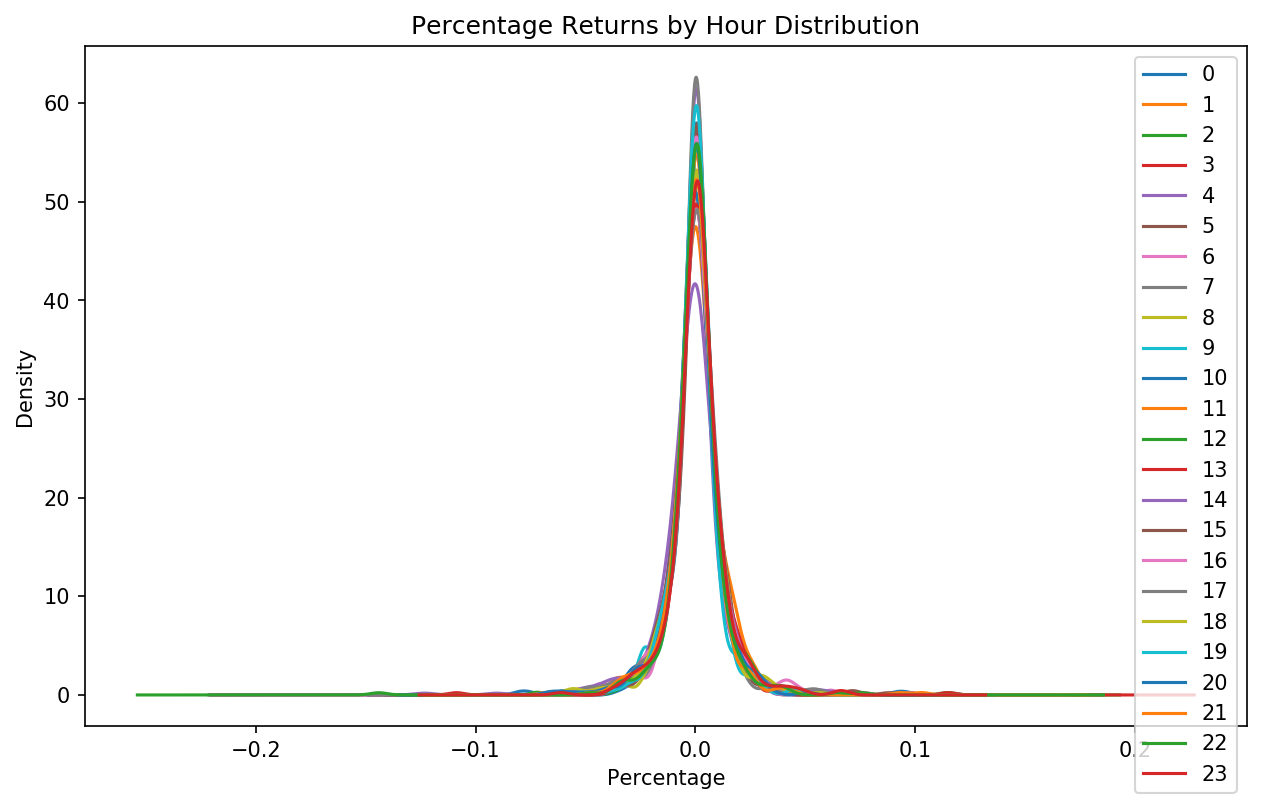

In [8]:
hourly_btc.plot.kde()
plt.title('Percentage Returns by Hour Distribution')
plt.xlabel('Percentage')

Text(0.5,1,'BTCUSD Hourly Percentage Return Distribution (2017/01/01 - 2018/04/18)')

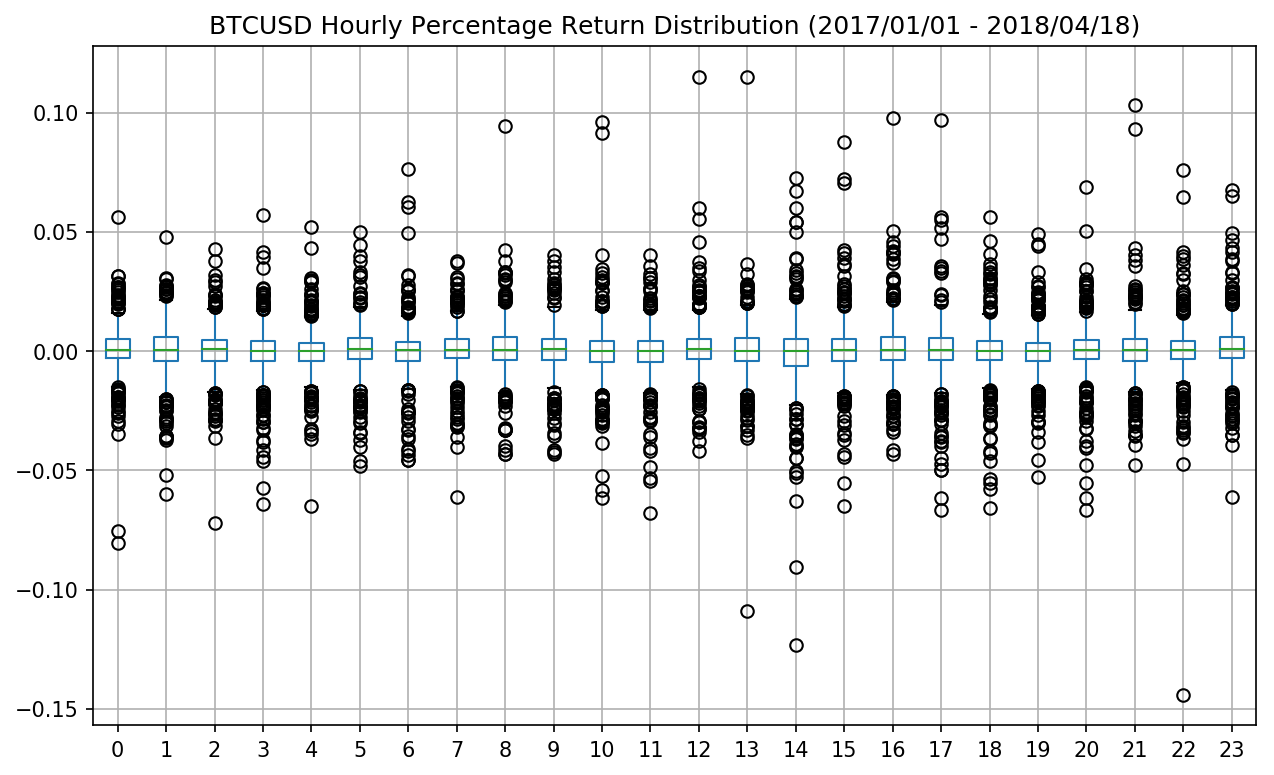

In [9]:
hourly_btc.boxplot()
plt.title('BTCUSD Hourly Percentage Return Distribution (2017/01/01 - 2018/04/18)')

Nothing seems out of the ordinary. I held a belief that perhaps Chinese miners dumping their coins at different hours of the day than standard USA trading hours, there might have been a noticeable change. However, that doesn't seem to be the case. They've probably automated the dumping after a block has been mined...

This begs the question, does a large move, say, $\|{\sigma}\| > 1$, imply a big move in the same direction afterwards? Let's explore

In [10]:
# Let's use log prices to account for explosive exponential growth
hourly = history['close']['BTCUSD'].apply(np.log).pct_change()

In [11]:
std_filter = (hourly > (2 * hourly.std()) + hourly.mean()) | (hourly < (-2 * hourly.std()) + hourly.mean())

We want to take these values, then track their cumulative return from that instance, until market close.

In [12]:
direction_data = {}

for idx, date in enumerate(hourly[std_filter].index):
    direction = hourly.loc[date] > 0
    end_of_day = date + timedelta(hours=24 - date.hour)
    direction_data[idx] = [date, int(direction), hourly.loc[date:end_of_day].sum()]
    
direction_data = pd.DataFrame(direction_data).T.set_index(0)
direction_data.columns = ['direction', 'pct_sum']
direction_data['pct_sum'] = direction_data.pct_sum.astype(np.float64)
direction_data['direction'] = direction_data.direction.astype(int)

Text(0.5,1,'2$\\sigma$ Forward Returns Distribution')

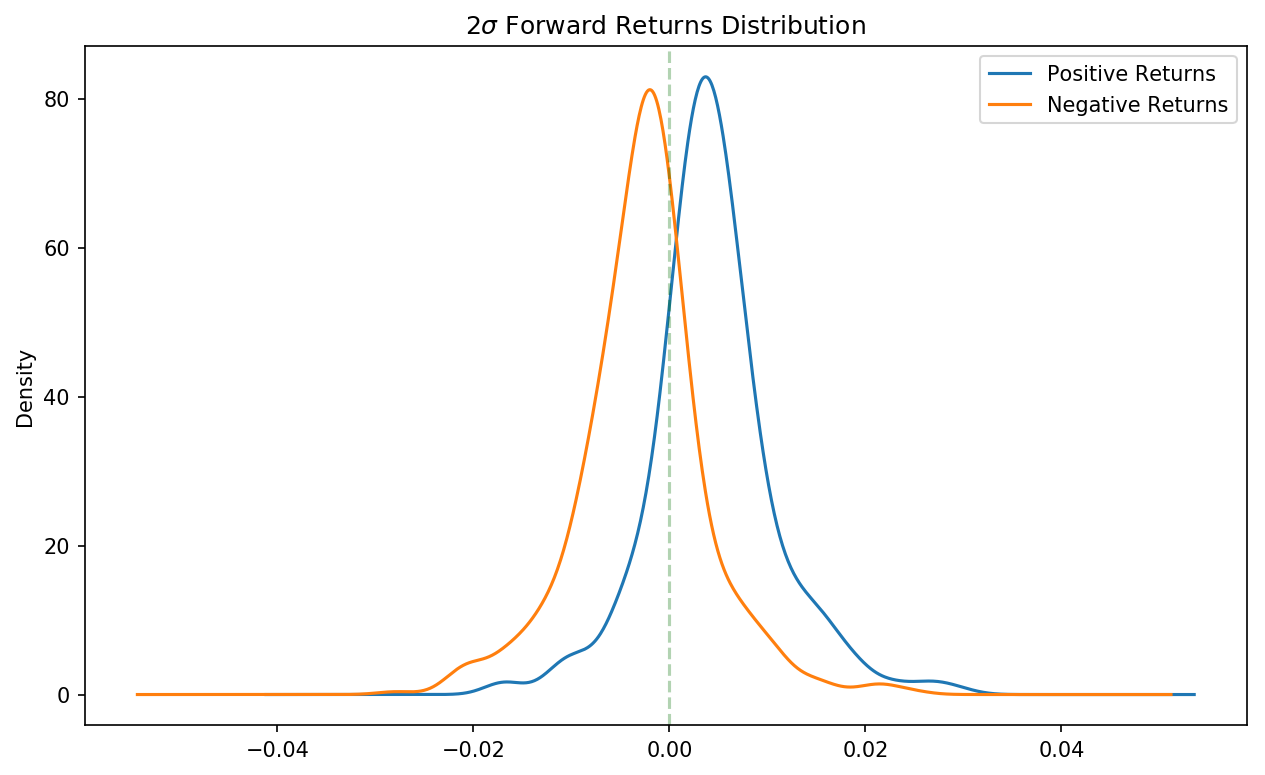

In [13]:
direction_data[direction_data['direction'] == 1]['pct_sum'].plot.kde()
direction_data[direction_data['direction'] == 0]['pct_sum'].plot.kde()
plt.axvline(0.00, c='#007000', linestyle='--', alpha=0.3)#the ultimate line that divides the boys from the men...
plt.legend(['Positive Returns', 'Negative Returns'])
plt.title(r'2$\sigma$ Forward Returns Distribution')

Seems to be that for the most part, our assumptions are true. However, there might be other factors affecting it in total, such as, a downtrend that was happening before a massive spike upwards in price. Let's analyze that using the same dataset as before, to avoid any mistakes in data

Let's proceed as follows:
* Seperate the data by direction

* Do a backwards walk and determine the overall trend from that data
    * NOTE: How will we select the cut-off point for the backwards walk?
    * Here's a better question, how long do cryptocurrency rallies last?
    
    
* Join backwards walk data with current DataFrame, then analyze data for trendiness (autocorrelation, etc)
* Make an improvised dataset where we subtract the upwards/downwards ticks from an oppositely-trending series, and see if we have an improvement in the classifiction of the data/more favorable distributions

In [14]:
upwards = direction_data[direction_data['direction'] == 1]
downwards = direction_data[direction_data['direction'] == 0]

In [15]:
def get_joined_lookback(df, hours_lookback=10):
    direction_points = []
    
    for date in df.index:
        # Should we include the data point that we already have in the analysis?
        # For these purposes, let's arbitrarily assign a lookback window of four hours
        backwards_date = date - timedelta(hours=hours_lookback)
        backwards_df = hourly.loc[backwards_date : date - timedelta(hours=1)]
        
        backwards_sum = backwards_df.sum()
        new_direction = int(backwards_sum > 0)
        autocorr_score= backwards_df.autocorr()
        
        direction_points.append([date, backwards_sum, int(new_direction), autocorr_score])

    direction_points = np.array(direction_points).T

    return pd.DataFrame({
        'date': direction_points[0],
        'backwards_pct_sum': direction_points[1], 
        'new_direction': direction_points[2],
        'autocorr': direction_points[3]
    }).set_index('date').join(df).infer_objects()

In [16]:
upwards_new = get_joined_lookback(upwards)
downwards_new = get_joined_lookback(downwards)

In [17]:
# Filter out the "incorrect" data points, i.e. wrong trend initially inferred
upwards_filt = upwards_new[upwards_new['new_direction'] == 1]
upwards_trash = upwards_new[upwards_new['new_direction'] == 0]

downwards_filt = downwards_new[downwards_new['new_direction'] == 0]
downwards_trash = downwards_new[downwards_new['new_direction'] == 1]

In [29]:
# Print a few statistics to keep the readers interested ;)
print('%.2f%% of datapoints in upwards were "incorrect"' % ((1 - (len(upwards_filt) / len(upwards)))*100))
print('%.2f%% of datapoints in downards were "incorrect"' % ((1 - (len(downwards_filt) / len(downwards)))*100))

50.84% of datapoints in upwards were "incorrect"
38.64% of datapoints in downards were "incorrect"


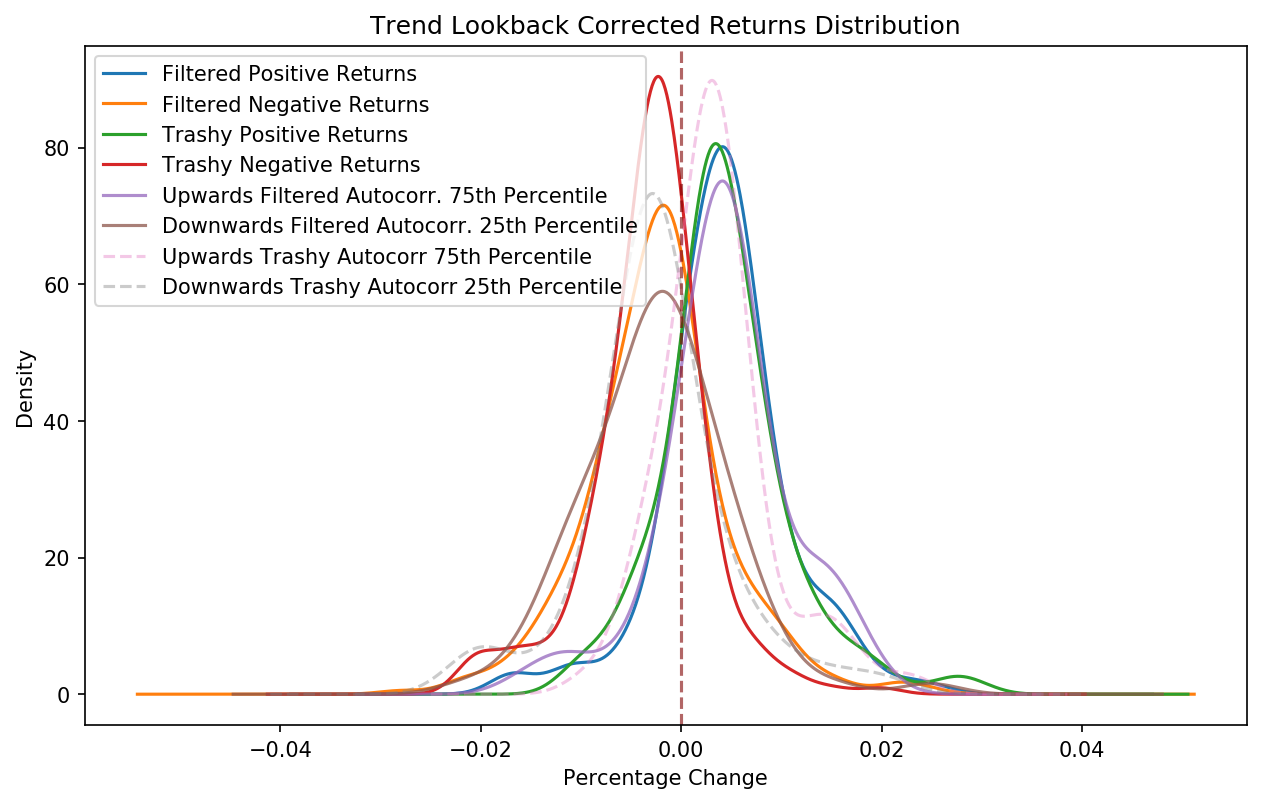

In [19]:
upwards_filt['pct_sum'].plot.kde()
downwards_filt['pct_sum'].plot.kde()

upwards_trash['pct_sum'].plot.kde()
downwards_trash['pct_sum'].plot.kde()

top_percentile = 0.75
bottom_percentile = 0.25

upwards_filt[upwards_filt['autocorr'] > upwards_filt['autocorr'].quantile(top_percentile)]['pct_sum'].plot.kde(alpha=0.75)
downwards_filt[downwards_filt['autocorr'] < downwards_filt['autocorr'].quantile(bottom_percentile)]['pct_sum'].plot.kde(alpha=0.75)

upwards_trash[upwards_trash['autocorr'] > upwards_trash['autocorr'].quantile(top_percentile)]['pct_sum'].plot.kde(alpha=0.4, linestyle='--')
downwards_trash[downwards_trash['autocorr'] < downwards_trash['autocorr'].quantile(bottom_percentile)]['pct_sum'].plot.kde(alpha=0.4, linestyle='--')

plt.title('Trend Lookback Corrected Returns Distribution')
plt.xlabel('Percentage Change')
plt.legend([
    'Filtered Positive Returns', 
    'Filtered Negative Returns', 
    'Trashy Positive Returns', 
    'Trashy Negative Returns',
    'Upwards Filtered Autocorr. %.0fth Percentile' % (top_percentile * 100),
    'Downwards Filtered Autocorr. %.0fth Percentile' % (bottom_percentile * 100),
    'Upwards Trashy Autocorr %.0fth Percentile' % (top_percentile * 100),
    'Downwards Trashy Autocorr %.0fth Percentile' % (bottom_percentile * 100)
])

plt.axvline(0.00, c='#800000', alpha=0.60, linestyle='--')

Make a scatterplot using autocorrelation and see if there's anything of worth on there.

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


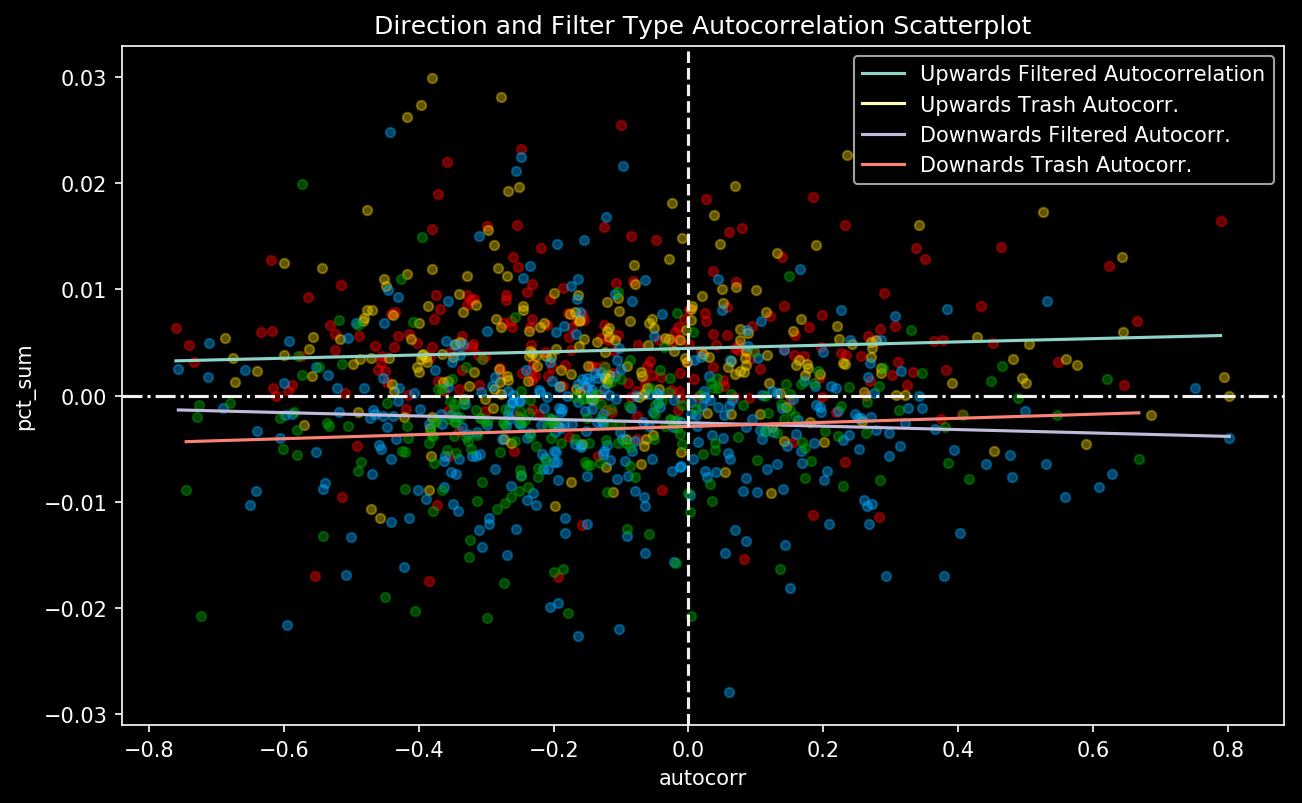

In [30]:
plt.style.use('dark_background')

ax = upwards_filt.plot.scatter('autocorr', 'pct_sum', alpha=0.4, c='#ff0000')
x = upwards_filt['autocorr']
y = upwards_filt['pct_sum']

# Plots line of best fit
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

upwards_trash.plot.scatter('autocorr', 'pct_sum', alpha=0.4, ax=ax, c='#f0d000')
x = upwards_trash['autocorr']
y = upwards_trash['pct_sum']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

downwards_filt.plot.scatter('autocorr', 'pct_sum', alpha=0.4, ax=ax, c='#00aaff')
x = downwards_filt['autocorr']
y = downwards_filt['pct_sum']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

downwards_trash.plot.scatter('autocorr', 'pct_sum', alpha=0.4, ax=ax, c='#00aa00')
x = downwards_trash['autocorr']
y = downwards_trash['pct_sum']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

plt.legend([
    'Upwards Filtered Autocorrelation', 
    'Upwards Trash Autocorr.', 
    'Downwards Filtered Autocorr.', 
    'Downards Trash Autocorr.'
])

plt.title('Direction and Filter Type Autocorrelation Scatterplot')
plt.axhline(0.00, c='#f0f0f0', linestyle='-.')
plt.axvline(0.00, c='#f0f0f0', linestyle='--')

No clear trend is discernable here from what it seems. Autocorrelation doesn't seem to be able to explain the direction of the trend in general or provide any good measurement for prediction in general unfortunately.

I'm going to wrap up this notebook because of the size limit QuantConnect has imposed in the research environment. Thanks for reading